### To Do

1. Sanity check first [done]
1. Band power with respect to stimulus onset -> to check if LFP is properly aligned [done]
2. Calculate hidden state distribution for each stimulus [done]
4. UMAP LFP inputs (should match the figure on the paper) [done]
4. Use LL to determine the optimum number of hidden states [done]
5. Calculate hidden state distributions with respect to hit and miss trials [done]
5. Delve into the means (result should resemble the power matrix) [done]
6. Compare the hit and miss trials [done]
> tomorrow
1. Power spectrum for hit/miss/omitted
1. Repeat with Day 1 session to see if similar results can be found
> just for fun lol
1. Try to find recurring patterns/sequences
1. Try to fix the spectrogram

### Libraries and dependencies

In [1]:
import gc
import umap
import numpy as np
import pandas as pd
from hmmlearn import hmm
from tqdm import tqdm
from copy import deepcopy
from scipy.stats import zscore, mode, entropy, sem
from matplotlib import pyplot as plt
from scipy.signal import butter, sosfiltfilt, hilbert, decimate, stft
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
output_dir = "E:/jerry/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)
probes = cache.get_probe_table() # type: ignore

e:\jerry\anaconda\envs\allensdk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1064644573 day 1

In [266]:
session = cache.get_ecephys_session(ecephys_session_id=1064644573) # type: ignore
probeA = session.get_lfp(1064735071) #VISam
probeB = session.get_lfp(1064735072) #VISpm
probeC = session.get_lfp(1064735073) #VISp
probeD = session.get_lfp(1064735075) #VISl
probeE = session.get_lfp(1064735076) #VISal
probeF = session.get_lfp(1064735077) #VISrl

KeyboardInterrupt: 

### 1055403683 day2

In [267]:
session = cache.get_ecephys_session(ecephys_session_id=1055403683) # type: ignore
probeA = session.get_lfp(1055529304) #VISam
probeB = session.get_lfp(1055529306) #VISpm
probeC = session.get_lfp(1055529307) #VISp
probeD = session.get_lfp(1055529308) #VISl
probeE = session.get_lfp(1055529309) #VISal
probeF = session.get_lfp(1055529310) #VISrl

KeyboardInterrupt: 

### Stims

In [264]:
# getting the start and end of stim block 0
sp = session.stimulus_presentations
sp = sp[sp['stimulus_block'] == 0]
start = sp.iloc[0].start_time
end = sp.iloc[-1].end_time
# 1000ms buffer in both ends, 250ms before start, 250Hz sampling rate (5x downsampled from 1250Hz)
master_time = np.arange(start-0.25-1, end+1, 1/250)
imgs = np.unique(sp['image_name'].values)

In [265]:
imgs

array(['im005_r', 'im024_r', 'im034_r', 'im083_r', 'im087_r', 'im104_r',
       'im111_r', 'im114_r', 'omitted'], dtype=object)

> Day 1: ['im005_r' 'im024_r' 'im034_r' 'im083_r' 'im087_r' 'im104_r' 'im111_r' 'im114_r' 'omitted']
> 

In [250]:
img = imgs[3]
print(img)
stim_img = stim[stim['image_name'] == img]
stim_start = stim_img.start_time.values[:200]

im083_r


## Filtering

In [240]:
def find_nearest_idx(array, value):
    idxs = np.zeros(len(value), dtype=int)
    for i, v in enumerate(value):
        idx = np.argmin(np.abs(np.array(array) - v))
        idxs[i] = idx
    return idxs

In [241]:
lfpA_slice = probeA.sel(time=master_time, method='nearest')
lfpB_slice = probeB.sel(time=master_time, method='nearest')
lfpC_slice = probeC.sel(time=master_time, method='nearest')
lfpD_slice = probeD.sel(time=master_time, method='nearest')
lfpE_slice = probeE.sel(time=master_time, method='nearest')
lfpF_slice = probeF.sel(time=master_time, method='nearest')
lfpA_copy = deepcopy(lfpA_slice)
lfpB_copy = deepcopy(lfpB_slice)
lfpC_copy = deepcopy(lfpC_slice)
lfpD_copy = deepcopy(lfpD_slice)
lfpE_copy = deepcopy(lfpE_slice)
lfpF_copy = deepcopy(lfpF_slice)

In [7]:
def testing(probe, num):
    ac47 = probe[:,num]
    bands = np.zeros((4, 200, 1250))
    Wns = [[3,8],[10,30],[30,50],[50,80]]
    for i, Wn in enumerate(Wns):
        sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos')
        for j, start in enumerate(stim_start):
            test = ac47.sel(time=slice(start-0.25, start+0.75)).values
            test_ff = sosfiltfilt(sos, test) 
            test_env = hilbert(test_ff)
            test_env_abs = np.abs(test_env)
            if len(test_env_abs) < 1250:
                bands[i][j][:len(test_env_abs)] = zscore(test_env_abs**2)
                bands[i][j][len(test_env_abs):] = zscore(test_env_abs[-1]**2)
            elif len(test_env_abs) > 1250:
                bands[i][j] = zscore(test_env_abs[:1250]**2)
            else:
                bands[i][j] = zscore(test_env_abs**2)
    avg = np.mean(bands, axis=1)
    plt.plot(avg[0].T, label='3-8')
    plt.plot(avg[1].T, label='10-30')
    plt.plot(avg[2].T, label='30-50')
    plt.plot(avg[3].T, label='50-80')
    plt.axvline(250/0.8, c='r')
    plt.axvline(500/0.8, c='r')
    plt.legend();
    return avg

### find nearest idx

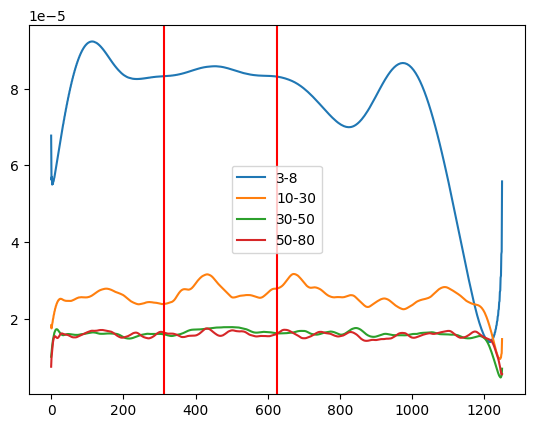

In [162]:
ac47=probeA[:,23]
bands = np.zeros((4, 200, 1250)) # 4 bands, 200 trials, 1250 time points
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in enumerate(Wns):
    sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos')
    for j, start in enumerate(stim_start):
        idx = np.arange(find_nearest_idx(ac47.time.values, start-0.25),find_nearest_idx(ac47.time.values, start+0.75))
        test = ac47.values[idx]
        test_ff = sosfiltfilt(sos, test) 
        test_env = hilbert(test_ff)
        test_env_abs = np.abs(test_env)
        if len(test_env_abs) < 1250:
            bands[i][j][:len(test_env_abs)] = test_env_abs
            bands[i][j][len(test_env_abs):] = test_env_abs[-1]
        elif len(test_env_abs) > 1250:
            bands[i][j] = test_env_abs[:1250]
        else:
            bands[i][j] = test_env_abs
avg = np.mean(bands, axis=1)
plt.plot(avg[0].T, label='3-8')
plt.plot(avg[1].T, label='10-30')
plt.plot(avg[2].T, label='30-50')
plt.plot(avg[3].T, label='50-80')
plt.axvline(250/0.8, c='r')
plt.axvline(500/0.8, c='r')
plt.legend()

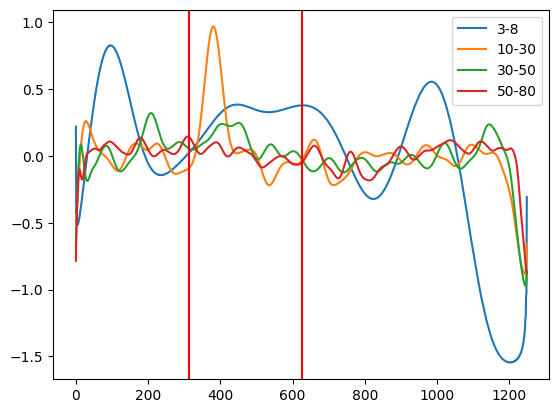

In [23]:
shared = testing(probeC, 23)

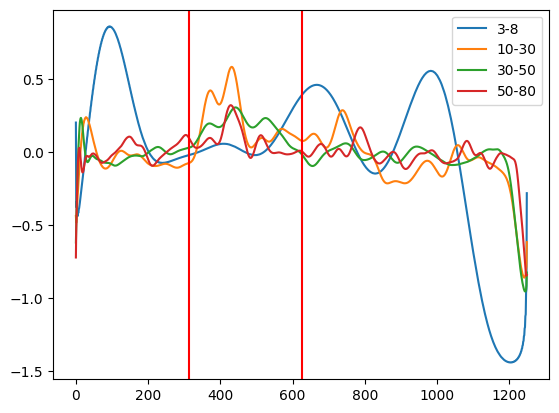

In [19]:
novel = testing(probeC, 23)

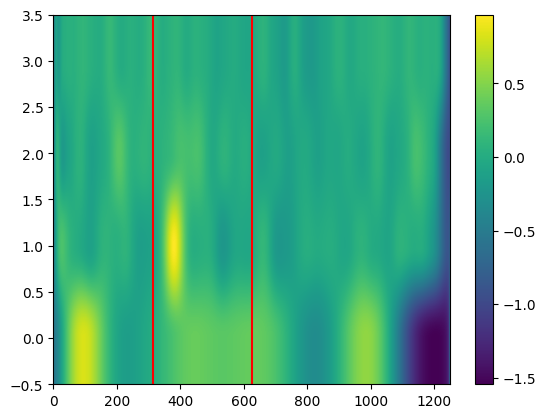

In [24]:
fig, ax = plt.subplots()
a = ax.imshow(shared, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

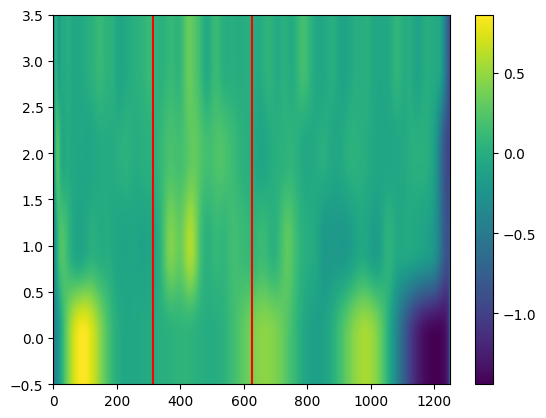

In [21]:
fig, ax = plt.subplots()
a = ax.imshow(novel, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

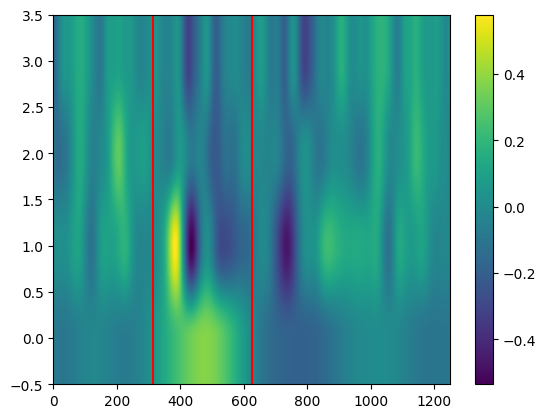

In [26]:
fig, ax = plt.subplots()
a = ax.imshow(shared-novel, aspect='auto')
ax.axvline(250/0.8, c='r')
ax.axvline(500/0.8, c='r')
ax.invert_yaxis()
fig.colorbar(a)

### sel and slice

In [242]:
mask = np.array([23])
A_chan = lfpA_copy[:,mask]
B_chan = lfpB_copy[:,mask]
C_chan = lfpC_copy[:,mask]
D_chan = lfpD_copy[:,mask]
E_chan = lfpE_copy[:,mask]
F_chan = lfpF_copy[:,mask]

In [243]:
print(A_chan.shape == B_chan.shape == C_chan.shape == D_chan.shape == E_chan.shape == F_chan.shape) # should all be the same

True


## GaussianHMM

### no downsampling

In [406]:
m_t.shape

(900841,)

In [ ]:
bands = np.zeros((4, 6, len(A_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.hstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
print(all_channels.shape)
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels.T) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
print(bands.shape)
#bands = np.reshape(bands,(4*18, len(A_chan)))
bands = np.reshape(bands,(4*6, len(A_chan)))
bands = bands[:,100:]
print(bands.shape)

In [72]:
find_nearest_idx(master_time,stim.iloc[0].start_time)-100

312

#### sanity checks

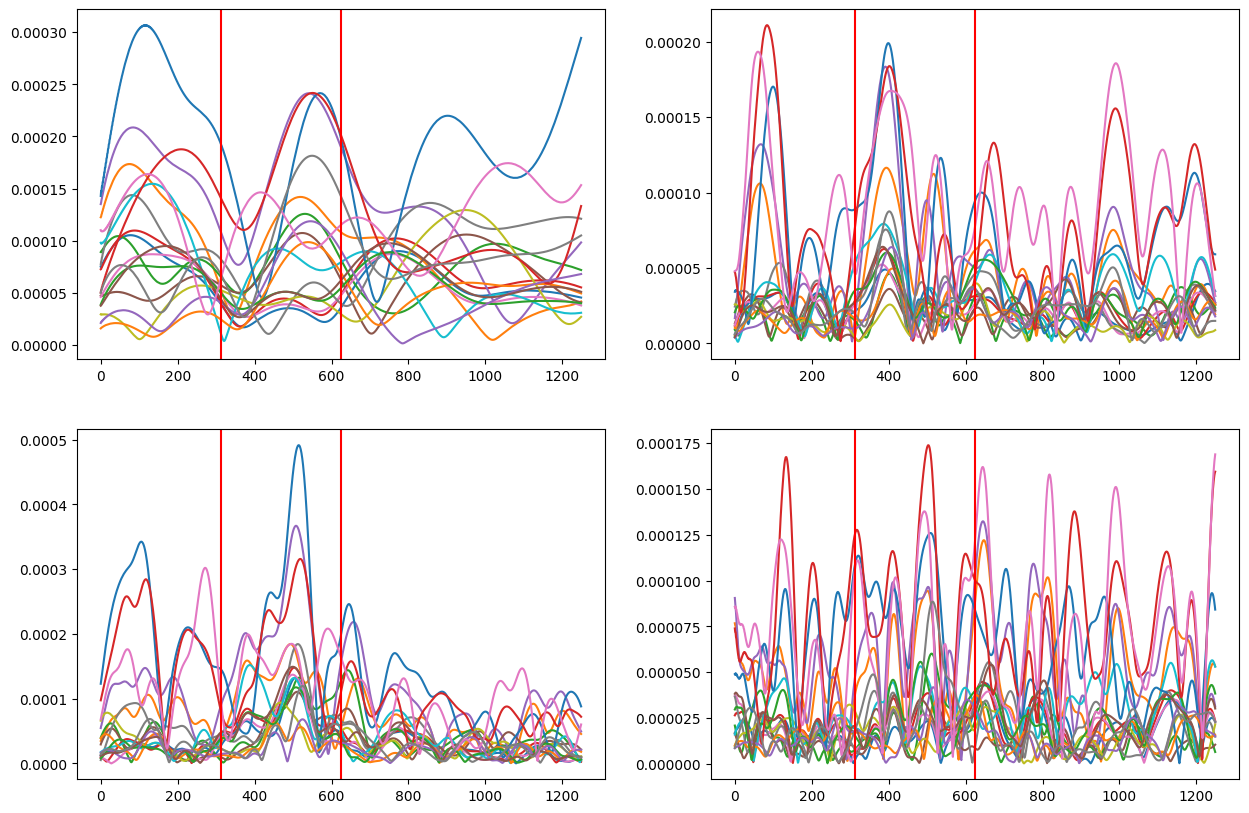

In [43]:
fig, axs=plt.subplots(2,2, figsize=(15,10))
for i in range(4):
    for j in range(18):
        axs[i%2][i//2].plot(bands[i*18+j].T[0:1250])
    axs[i%2][i//2].axvline(250/0.8, c='r')
    axs[i%2][i//2].axvline(500/0.8, c='r')

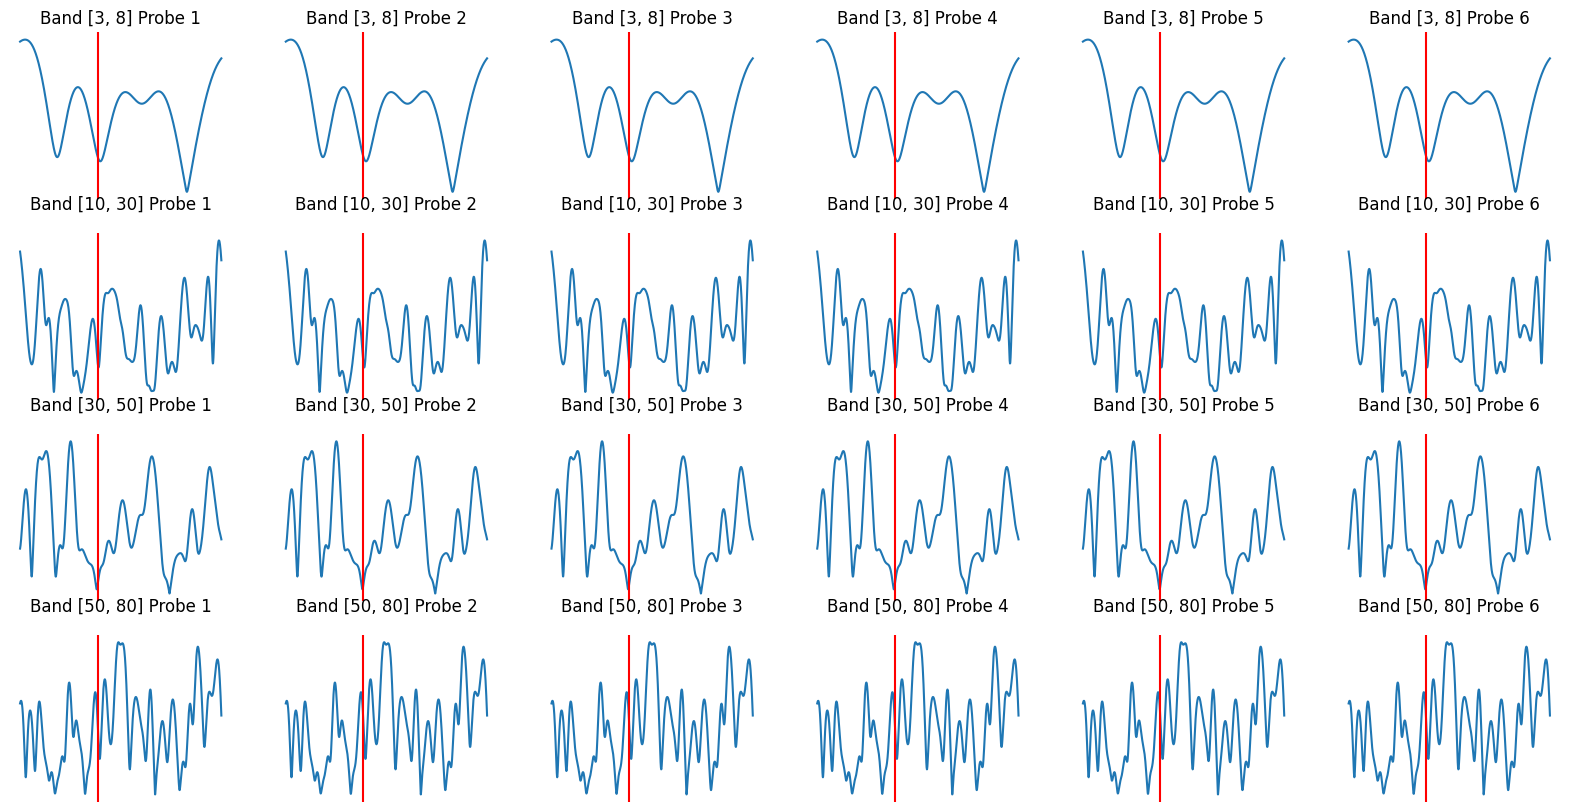

In [38]:
start = stim.iloc[3].start_time
near_idx = find_nearest_idx(probeC.time.values, [start]) # type: ignore
fig, axs = plt.subplots(4, 6, figsize=(20, 10))
for i in range(4):
    for j in range(6):
        axs[i, j].plot(bands[i, j].T[near_idx-500:near_idx+800])
        axs[i, j].axvline(500, c='r')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Band {Wns[i]} Probe {j+1}')


#### end

In [65]:
bands_z = zscore(bands, axis=1)
bands_z_0 = zscore(bands, axis=0)

In [163]:
m_t = master_time[100:] # to remove the 100 paddings
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,4))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]

9it [05:30, 36.71s/it]


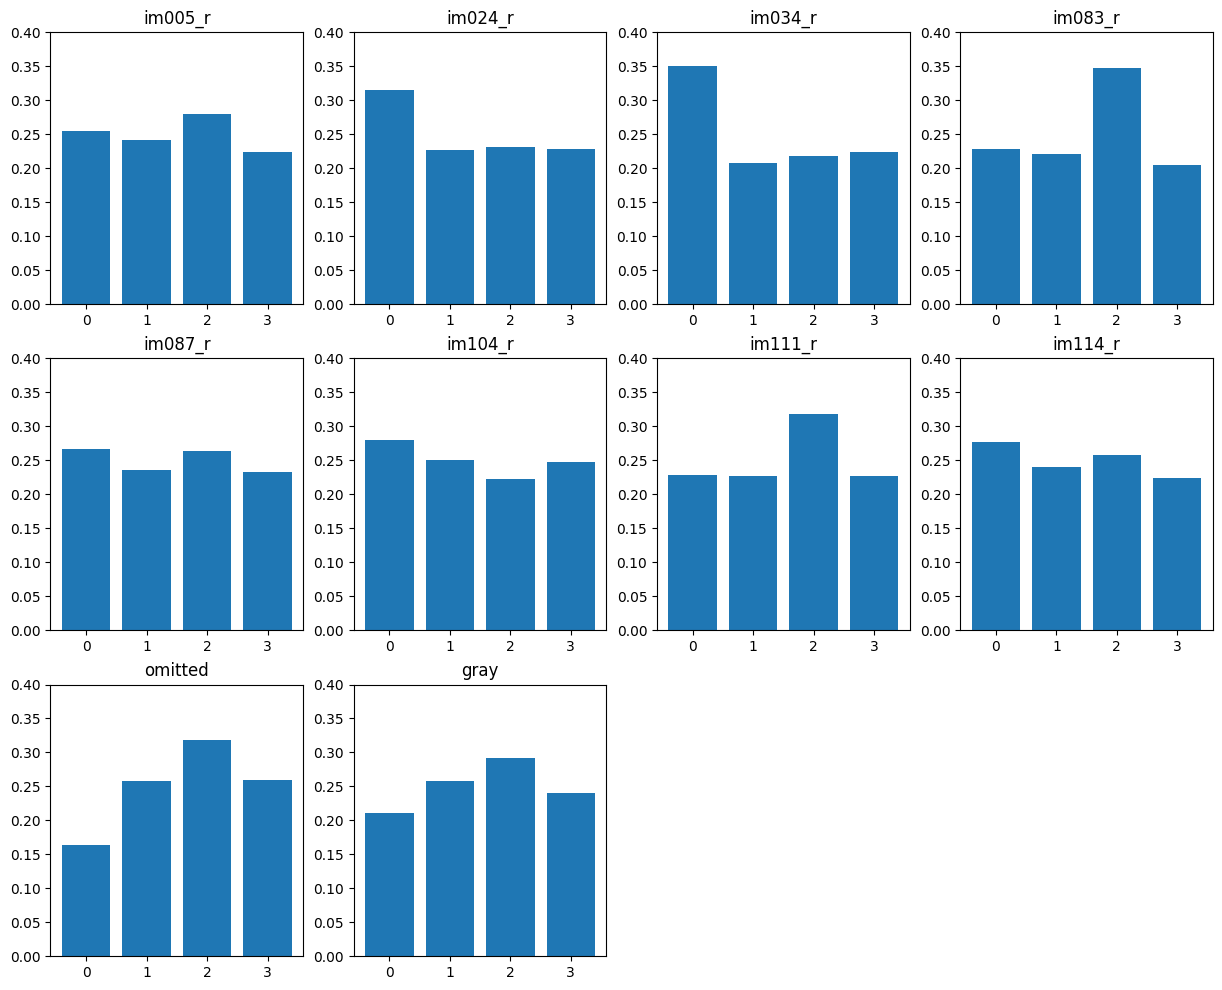

In [171]:
u_preds=preds[90:][u_mask==1]
unique, counts = np.unique(u_preds, return_counts=True)
for i, u in enumerate(unique):
    distribution[-1][u] += counts[i]
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])
fig,axs = plt.subplots(3, 4, figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(4), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.41,0.05))        

In [178]:
entropies = np.zeros(10)
for i in range(len(d)):
    entropies[i] = entropy(d[i])

In [175]:
h_r_path = "E:/jerry/hit_rates/1055403683.npz"
np.load(h_r_path, allow_pickle=True)['h_r']

array([0.58333333, 0.71428571, 0.7027027 , 0.        , 0.79411765,
       0.82352941, 0.14285714, 0.88888889])

In [161]:
file_path="E:/jerry/temp/preds/4_1.npz"
np.savez(file_path, preds=preds)

In [173]:
file_path="E:/jerry/temp/distributions/4_1.npz"
np.savez(file_path, distribution=distribution)

In [ ]:
m_t = master_time[100:] # to remove the 100 paddings
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,8))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
    #axs[s_idx//3][s_idx%3].bar(np.arange(8), zscore(distribution))
    #axs[s_idx//3][s_idx%3].set_title(s)

In [136]:
u_preds=preds[90:][u_mask==1]
unique, counts = np.unique(u_preds, return_counts=True)
for i, u in enumerate(unique):
    distribution[-1][u] += counts[i]
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])
fig,axs = plt.subplots(3,4,figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(8), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.26,0.05))
        

In [145]:
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])

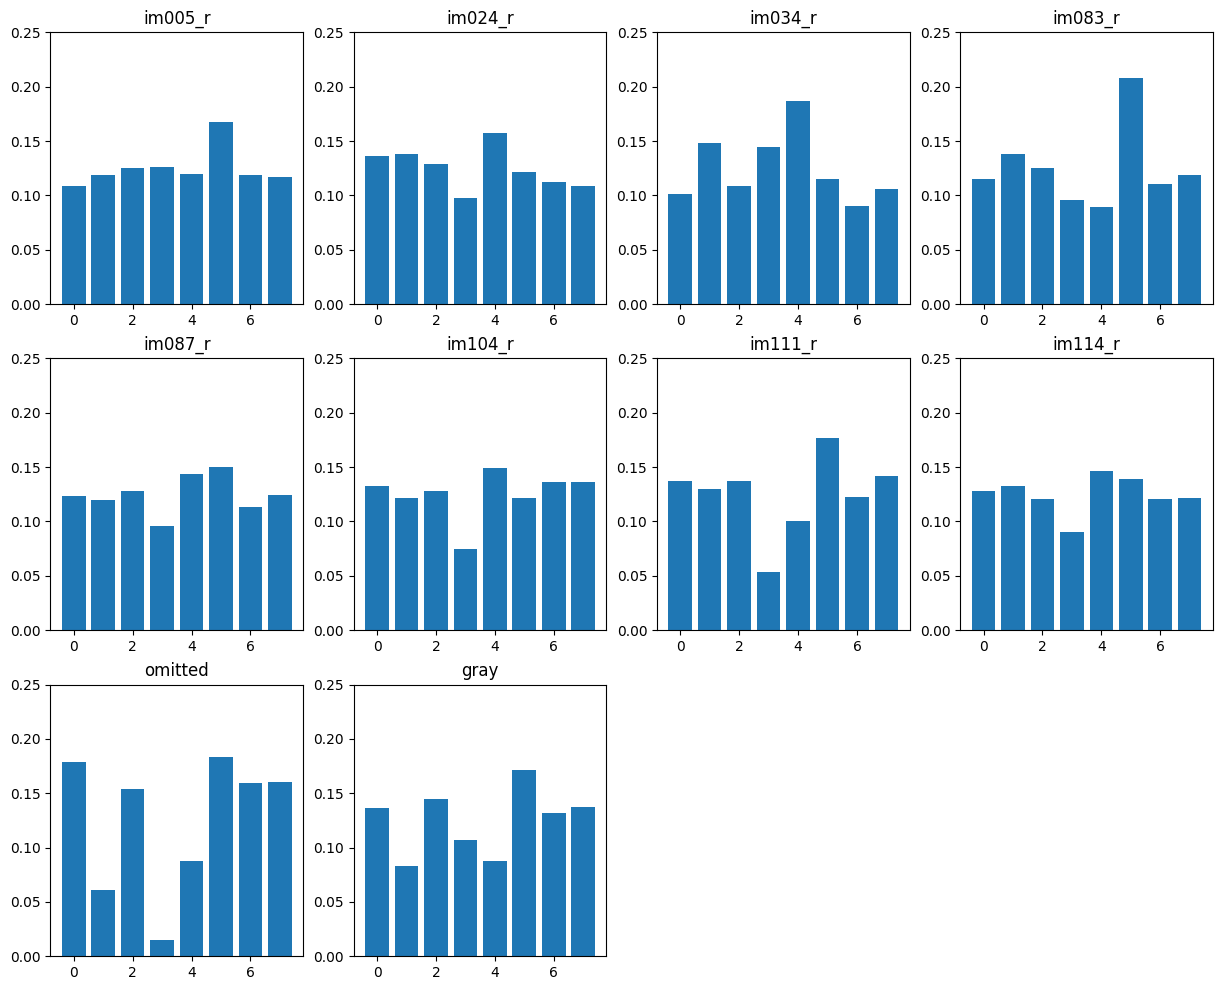

In [152]:
fig,axs = plt.subplots(3,4,figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(8), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.26,0.05))
        

### 2x downsample

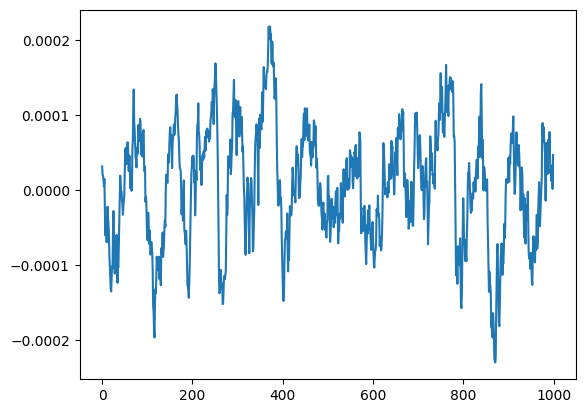

In [230]:
temp = np.reshape(A_chan, (1,-1))
A_chan_down = decimate(temp, 2)
plt.plot(A_chan_down[0][0:1000])

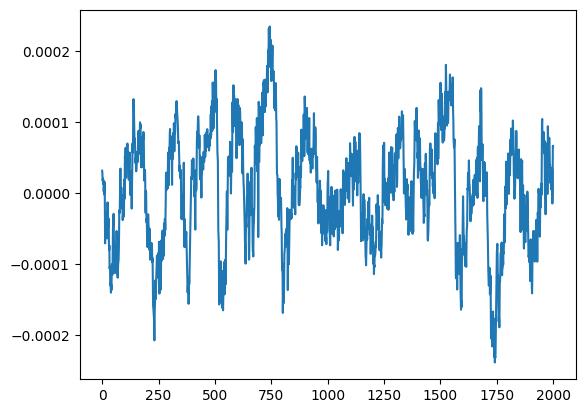

In [205]:
plt.plot(A_chan[0:2000])

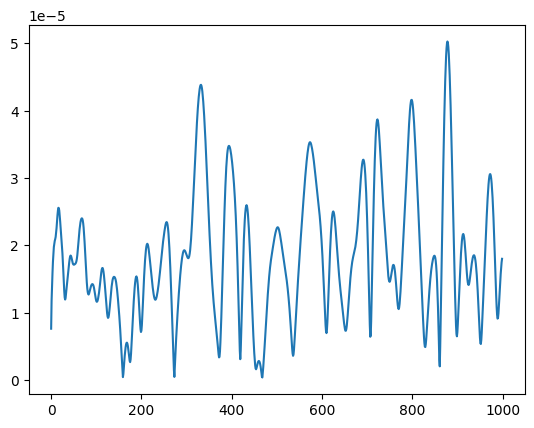

In [211]:
sos = butter(N=3, Wn=[50,80], fs=625, btype='bandpass', output='sos')
A_chan_ff = sosfiltfilt(sos, A_chan_down[0])
A_chan_env = hilbert(A_chan_ff)
A_chan_env_abs = np.abs(A_chan_env)
plt.plot(A_chan_env_abs[0:1000])

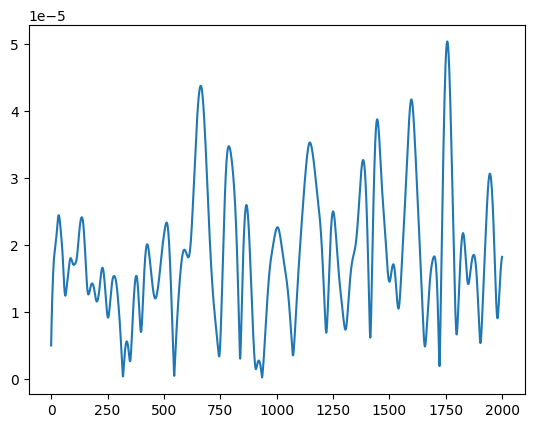

In [212]:
sos = butter(N=3, Wn=[50,80], fs=1250, btype='bandpass', output='sos')
A_chan_ff = sosfiltfilt(sos, A_chan[:,0])
A_chan_env = hilbert(A_chan_ff)
A_chan_env_abs = np.abs(A_chan_env)
plt.plot(A_chan_env_abs[0:2000])

In [216]:
A_chan_down = decimate(A_chan.T[0], 2, axis=0)
B_chan_down = decimate(B_chan.T[0], 2, axis=0)
C_chan_down = decimate(C_chan.T[0], 2, axis=0)
D_chan_down = decimate(D_chan.T[0], 2, axis=0)
E_chan_down = decimate(E_chan.T[0], 2, axis=0)
F_chan_down = decimate(F_chan.T[0], 2, axis=0)

In [221]:
print(A_chan_down.shape)

(2252152,)


In [222]:
bands = np.zeros((4, 6, len(A_chan_down))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.vstack((A_chan_down, B_chan_down, C_chan_down, D_chan_down, E_chan_down, F_chan_down))
print(all_channels.shape)
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=625, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
print(bands.shape)
bands = np.reshape(bands,(4*6, len(A_chan_down)))
bands = bands[:,100:]
print(bands.shape)
bands_z = zscore(bands, axis=1)
bands_z_0 = zscore(bands, axis=0)

(6, 2252152)
(4, 6, 2252152)
(24, 2252052)


In [231]:
bands_z = zscore(bands, axis=1)
bands_z_0 = zscore(bands, axis=0)

In [232]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=1)
model.fit(bands_z_0.T)
preds = model.predict(bands_z_0.T)

         1 -41206856.37537061             +nan
         2 -33106480.14702451 +8100376.22834609
         3 -31185640.34979964 +1920839.79722488
         4 -30687663.79522775 +497976.55457189
         5 -30397177.15759529 +290486.63763246
         6 -30213505.16384083 +183671.99375445
         7 -30124591.57924938  +88913.58459145
         8 -30088215.17257499  +36376.40667439
         9 -30073663.19506229  +14551.97751270
        10 -30067455.04956751   +6208.14549478
        11 -30064641.86176614   +2813.18780137
        12 -30063248.74514197   +1393.11662417
        13 -30062497.04777959    +751.69736239
        14 -30062072.29449535    +424.75328423
        15 -30061826.93134756    +245.36314779
        16 -30061681.58202077    +145.34932679
        17 -30061590.99826552     +90.58375525
        18 -30061531.40473909     +59.59352643
        19 -30061490.43005655     +40.97468254
        20 -30061461.15811455     +29.27194200
        21 -30061439.48195969     +21.67615486
        22 

In [233]:
print(master_time)

[  25.16450032   25.16530032   25.16610032 ... 3628.60530033 3628.60610033
 3628.60690033]


In [234]:
master_time = np.arange(start-0.25-0.08, end, 1/625) # 250ms b4 start to end sliced by 1.6ms <- sampling rate of LFP; also 80ms before stim start to avoid edge effects

In [235]:
m_t = master_time[50:] # to remove the 100 paddings
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,4))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]

9it [02:39, 17.71s/it]


### 5x downsample

##### testing downsample

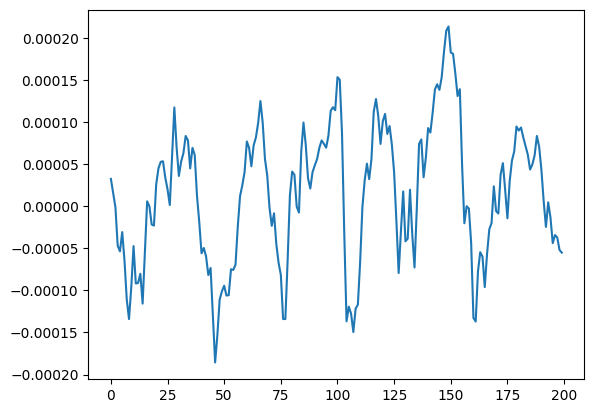

In [248]:
temp = np.reshape(A_chan, (1,-1))
A_chan_down = decimate(temp, 5)
plt.plot(A_chan_down[0][0:200])

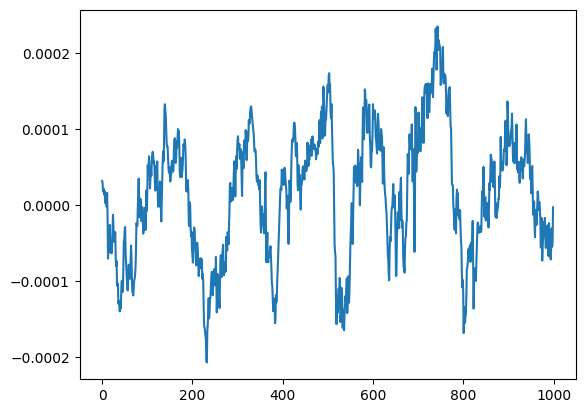

In [249]:
plt.plot(A_chan[0:1000])

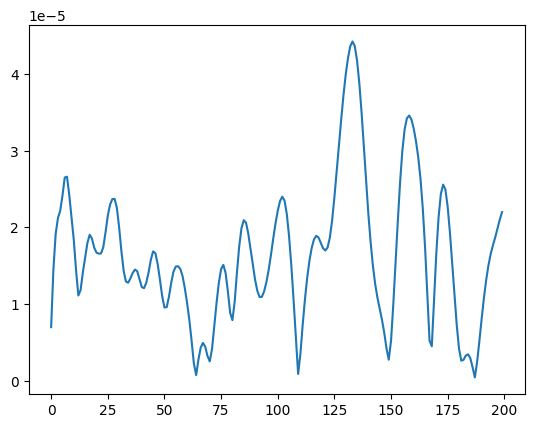

In [258]:
sos = butter(N=3, Wn=[50,80], fs=250, btype='bandpass', output='sos')
A_chan_ff = sosfiltfilt(sos, A_chan_down[0])
A_chan_env = hilbert(A_chan_ff)
A_chan_env_abs = np.abs(A_chan_env)
plt.plot(A_chan_env_abs[0:200])

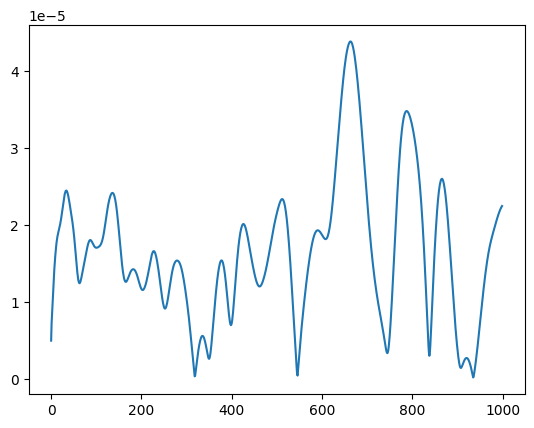

In [257]:
sos = butter(N=3, Wn=[50,80], fs=1250, btype='bandpass', output='sos')
A_chan_ff = sosfiltfilt(sos, A_chan.T[0])
A_chan_env = hilbert(A_chan_ff)
A_chan_env_abs = np.abs(A_chan_env)
plt.plot(A_chan_env_abs[0:1000])

In [255]:
# 5x downsample
stim_pre = session.stimulus_presentations
stim = stim_pre[stim_pre['stimulus_name'].str.contains('Natural')]
stim = stim[stim['stimulus_block'] == 0]
stim_times = stim.start_time.values # all the start times
stim_ids = stim.index.values # all the stimulus ids
start = stim.iloc[0].start_time
end = stim.iloc[-1].end_time
master_time = np.arange(start-0.25-1, end+1, 1/250) # 1000ms buffer on both sides
imgs = np.unique(stim['image_name'].values)
lfpA_slice = probeA.sel(time=master_time, method='nearest')
lfpB_slice = probeB.sel(time=master_time, method='nearest')
lfpC_slice = probeC.sel(time=master_time, method='nearest')
lfpD_slice = probeD.sel(time=master_time, method='nearest')
lfpE_slice = probeE.sel(time=master_time, method='nearest')
lfpF_slice = probeF.sel(time=master_time, method='nearest')
lfpA_copy = deepcopy(lfpA_slice)
lfpB_copy = deepcopy(lfpB_slice)
lfpC_copy = deepcopy(lfpC_slice)
lfpD_copy = deepcopy(lfpD_slice)
lfpE_copy = deepcopy(lfpE_slice)
lfpF_copy = deepcopy(lfpF_slice)

In [257]:
lfpA_copy.shape == lfpB_copy.shape == lfpC_copy.shape == lfpD_copy.shape == lfpE_copy.shape == lfpF_copy.shape

False

In [258]:
mask = np.array([23])
A_chan = lfpA_copy[:,mask].T[0]
B_chan = lfpB_copy[:,mask].T[0]
C_chan = lfpC_copy[:,mask].T[0]
D_chan = lfpD_copy[:,mask].T[0]
E_chan = lfpE_copy[:,mask].T[0]
F_chan = lfpF_copy[:,mask].T[0]

In [9]:
bands = np.zeros((4, 6, len(A_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.vstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env) # type: ignore
    bands[i] = all_channels_env_abs
bands = np.reshape(bands,(4*6, len(A_chan)))
print(bands.shape)
bands = bands[:,250:-250].T
print(bands.shape)
bands_z = zscore(bands, axis=1)
bands_z_0 = zscore(bands, axis=0)
print(bands_z.shape)

(24, 901341)
(900841, 24)
(900841, 24)


In [297]:
model = hmm.GaussianHMM(n_components=6, n_iter=1000, verbose=True, tol=1)
model.fit(bands_z)
preds = model.predict(bands_z)

         1 -17404556.57626514             +nan
         2 -13036645.40683549 +4367911.16942965
         3 -12423829.75913774 +612815.64769774
         4 -12345852.12434520  +77977.63479254
         5 -12320119.67900643  +25732.44533877
         6 -12308946.05182927  +11173.62717717
         7 -12303163.04220588   +5783.00962339
         8 -12299751.84196905   +3411.20023683
         9 -12297522.79809698   +2229.04387206
        10 -12295918.32892793   +1604.46916905
        11 -12294647.43598677   +1270.89294116
        12 -12293500.24666488   +1147.18932190
        13 -12292413.77236417   +1086.47430070
        14 -12291361.60132928   +1052.17103489
        15 -12290280.94241445   +1080.65891483
        16 -12289099.82411715   +1181.11829729
        17 -12287703.93559186   +1395.88852529
        18 -12286038.78455327   +1665.15103859
        19 -12283945.86206629   +2092.92248698
        20 -12281356.38858274   +2589.47348355
        21 -12278335.33801635   +3021.05056640
        22 -

In [299]:
m_t = master_time[100:] # to remove the 100 paddings

(900941,)

In [302]:
m_t = master_time[100:]
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,6))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
u_preds=preds[u_mask==1]
unique, counts = np.unique(u_preds, return_counts=True)



9it [01:03,  7.10s/it]


In [314]:
file_path="E:/jerry/temp/preds/6_1_5d_z.npz"
np.savez(file_path, preds=preds)
file_path="E:/jerry/temp/distributions/6_1_5d_z.npz"
np.savez(file_path, distribution=distribution)


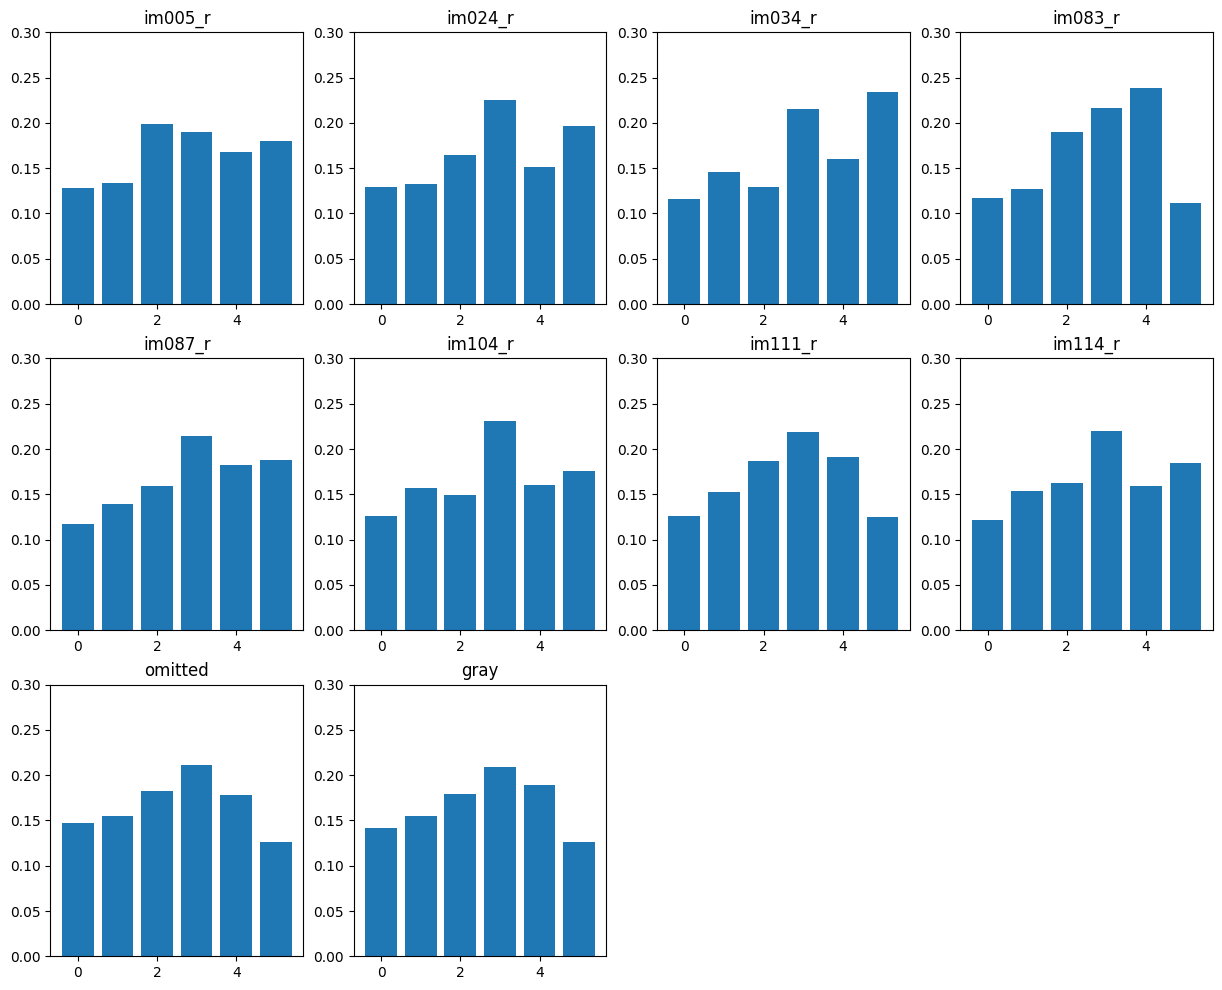

In [303]:
for i, u in enumerate(unique):
    distribution[-1][u] += counts[i]
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])
fig,axs = plt.subplots(3, 4,figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(6), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.31,0.05))

In [312]:
model = hmm.GaussianHMM(n_components=6, n_iter=1000, verbose=True, tol=1)
model.fit(bands_z_0)
preds = model.predict(bands_z_0)

         1 -29864225.43601115             +nan
         2 -26616519.26253706 +3247706.17347409
         3 -26080811.74993639 +535707.51260067
         4 -25999154.53446591  +81657.21547049
         5 -25969764.98243345  +29389.55203245
         6 -25957186.40068572  +12578.58174773
         7 -25951257.46584202   +5928.93484370
         8 -25948064.95596519   +3192.50987682
         9 -25946111.01035380   +1953.94561139
        10 -25944781.57702428   +1329.43332952
        11 -25943799.42707980    +982.14994447
        12 -25942994.69702521    +804.73005459
        13 -25942329.09069883    +665.60632638
        14 -25941785.67594625    +543.41475258
        15 -25941329.17280088    +456.50314537
        16 -25940943.51354233    +385.65925856
        17 -25940616.68383995    +326.82970238
        18 -25940342.83477740    +273.84906255
        19 -25940120.25833813    +222.57643927
        20 -25939939.13276085    +181.12557728
        21 -25939788.93075705    +150.20200380
        22 -

In [328]:
m_t = master_time[100:]
all_stims = np.unique(stim['image_name'].values)
u_mask = np.ones(len(m_t), dtype=int)
distribution=np.zeros((10,6))
for s_idx, s in tqdm(enumerate(all_stims)):
    stim_start = stim[stim['image_name'] == s].start_time.values
    stim_end = stim[stim['image_name'] == s].end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
u_preds=preds[u_mask==1]
unique, counts = np.unique(u_preds, return_counts=True)

9it [01:09,  7.77s/it]


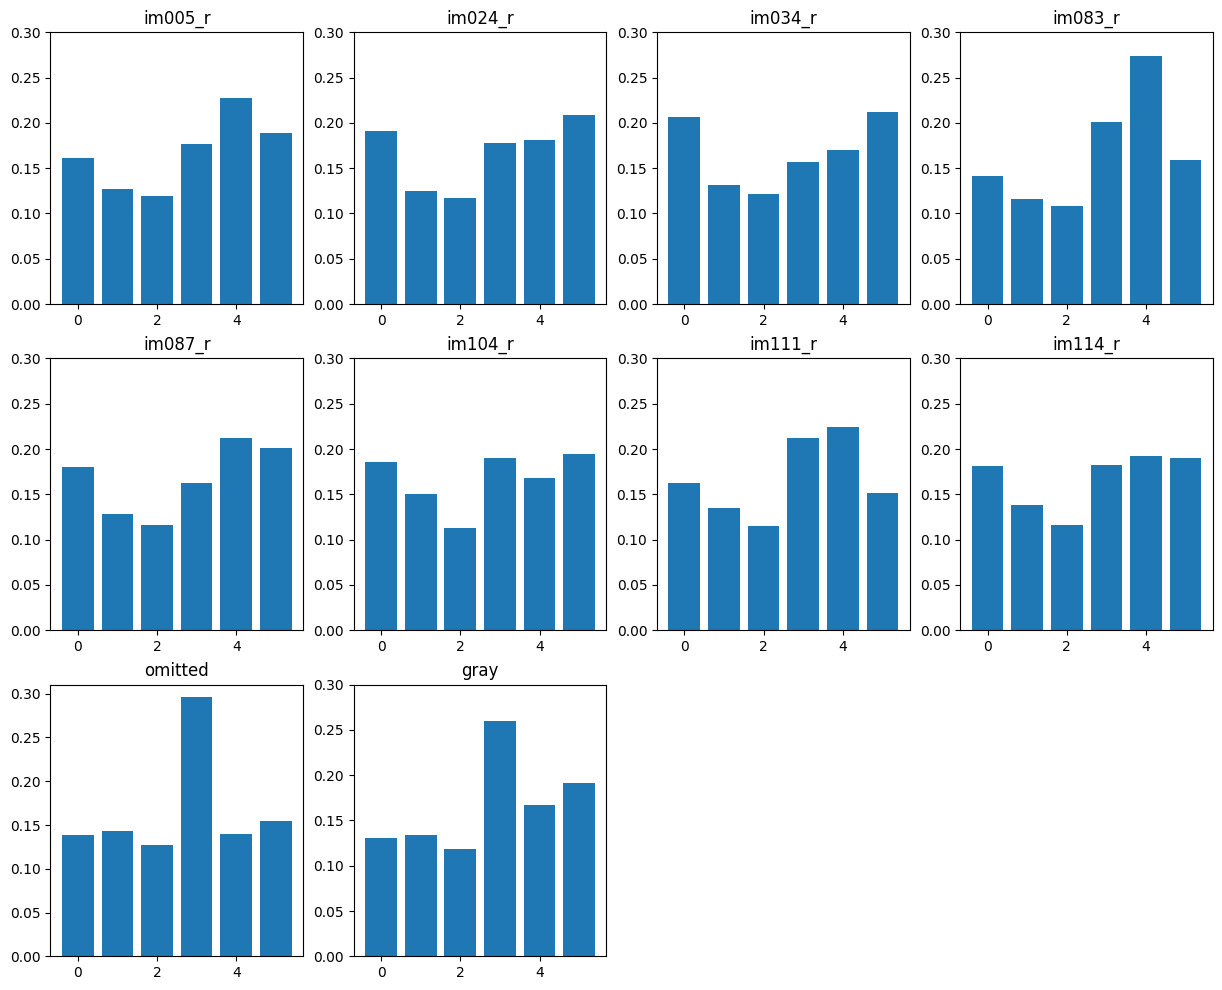

In [329]:
for i, u in enumerate(unique):
    distribution[-1][u] += counts[i]
d = deepcopy(distribution)
for i in range(10):
    d[i] = d[i]/np.sum(d[i])
fig,axs = plt.subplots(3, 4,figsize=(15,12))
for i in range(3):
    for j in range(4):
        try:
            axs[i][j].bar(np.arange(6), d[i*4+j])
        except:
            axs[i][j].axis('off')
            continue
        try:
            axs[i][j].set_title(all_stims[i*4+j])
        except:
            axs[i][j].set_title('gray')
        axs[i][j].set_yticks(np.arange(0,0.31,0.05))

###### LL and elbow test

In [ ]:
ns = np.arange(2,21)
lls = np.zeros(len(ns))
for i, n in tqdm(enumerate(ns)):
    ll_temp = 0
    for iter in range(3):
        model = hmm.GaussianHMM(n_components=n, n_iter=1000, verbose=False, tol=0.1)
        model.fit(bands_z_0)
        ll_temp+=model.score(bands_z_0)
    lls[i] = ll_temp/3

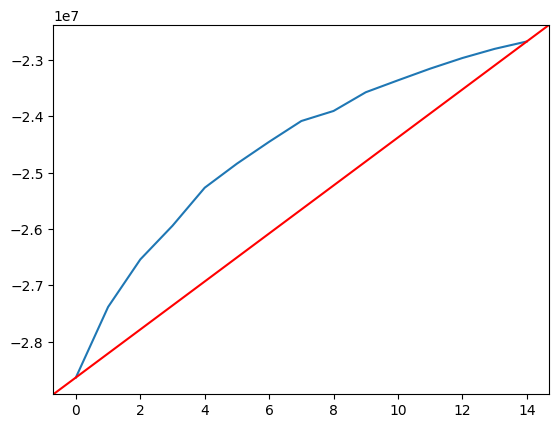

In [373]:
plt.plot(np.arange(len(lls)-4), lls[:-4])
plt.axline((0, lls[0]), (len(lls)-5, lls[-5]), c='r')

In [378]:
lls_new = lls[:-4]
slope = (lls_new[-1]-lls_new[0])/(len(lls_new)-1)
intercept = lls_new[0]


In [376]:
def d(slope, intercept, x1, y1):
    return np.abs(slope*x1-y1+intercept)/np.sqrt(slope**2+1)

In [381]:
ds = np.zeros(len(lls_new))
for i in range(len(lls_new)):
    ds[i]=d(slope, intercept, i, lls_new[i])

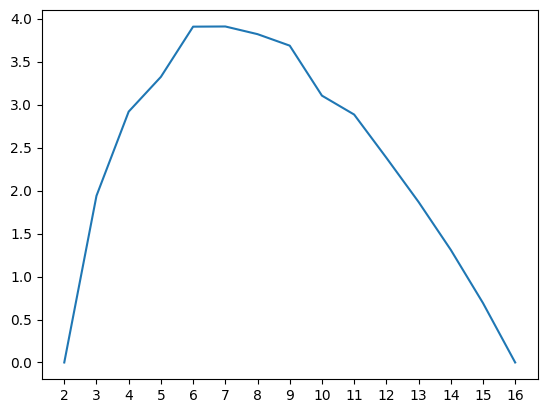

In [386]:
plt.plot(np.arange(len(ds)), ds)
plt.xticks(ticks=np.arange(len(ds)), labels=np.arange(len(ds))+2);

In [437]:
ds_penal = np.zeros(len(lls_new))
for i in range(len(lls_new)):
    ds_penal[i]=d(slope, intercept, i, lls_new[i])/(i+2)

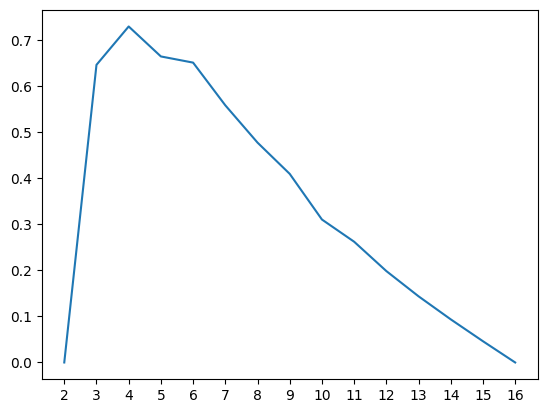

In [438]:
plt.plot(np.arange(len(ds_penal)), ds_penal)
plt.xticks(ticks=np.arange(len(ds_penal)), labels=np.arange(len(ds_penal))+2);

##### 7 hidden states

In [253]:
# plotting state
def plot(preds, num=3):
    temp_p = preds[int(250/4):]
    plt.plot(temp_p[0:int(750*num/4)])
    start_time = 0
    for i in range(num):
        plt.axvspan(start_time/4, (start_time+250)/4, alpha=0.2, color='red') # stimulus
        start_time += 250
        plt.axvspan(start_time/4, (start_time+500)/4, alpha=0.2, color='gray') # gray
        start_time += 500

In [392]:
model = hmm.GaussianHMM(n_components=7, n_iter=1000, verbose=True, tol=0.1)
model.fit(bands_z_0)
preds = model.predict(bands_z_0)

         1 -28316861.32027159             +nan
         2 -25857204.05216002 +2459657.26811157
         3 -25574615.28050420 +282588.77165583
         4 -25505855.61116751  +68759.66933668
         5 -25464567.58805370  +41288.02311381
         6 -25431172.42865580  +33395.15939790
         7 -25382390.74091869  +48781.68773711
         8 -25153757.01114375 +228633.72977494
         9 -24965686.15782778 +188070.85331597
        10 -24900730.43477992  +64955.72304786
        11 -24883581.20396138  +17149.23081855
        12 -24876461.91689329   +7119.28706808
        13 -24872155.76082371   +4306.15606958
        14 -24868979.68823003   +3176.07259368
        15 -24865922.20218900   +3057.48604103
        16 -24862605.23154704   +3316.97064196
        17 -24858611.34801569   +3993.88353135
        18 -24853991.41308084   +4619.93493485
        19 -24848977.19412598   +5014.21895486
        20 -24843615.76030999   +5361.43381599
        21 -24838379.52934527   +5236.23096472
        22 -

In [398]:
print(bands_z_0.shape)

(900841, 24)


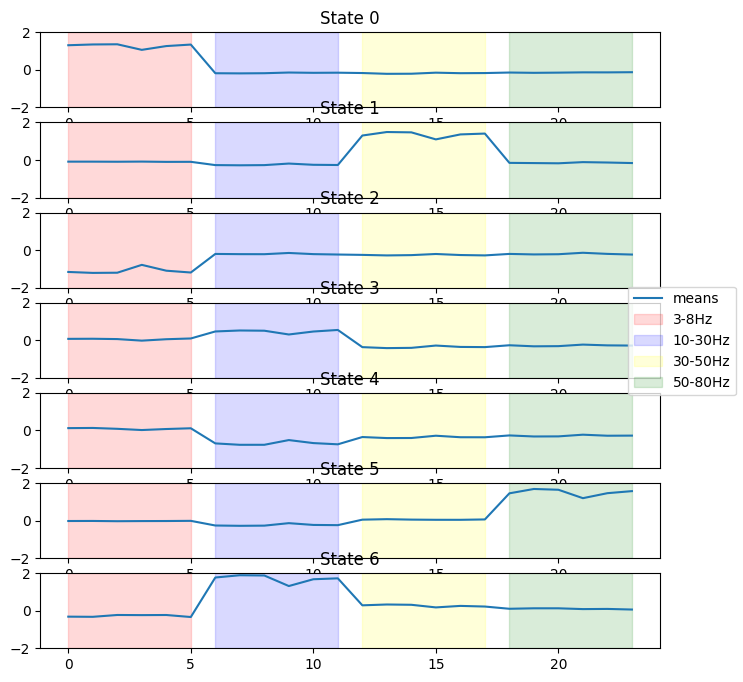

In [432]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,8))
for i in range(len(model.means_)):
    axs[i].plot(model.means_[i])
    axs[i].set_yticks(np.linspace(-2,2,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
fig.legend(['means','3-8Hz','10-30Hz','30-50Hz','50-80Hz'], loc='center right')

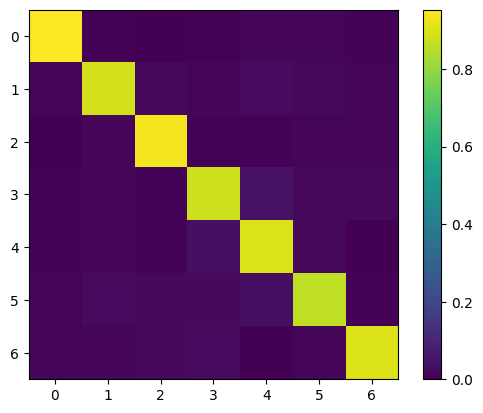

In [436]:
plt.imshow(model.transmat_)
plt.colorbar()

In [29]:
def plot_dist(master_time, stim, preds, num, ylim):
    y_inc = ylim/5
    ylim = y_inc*5+0.01
    m_t = master_time[100:]
    all_stims = np.unique(stim['image_name'].values)
    u_mask = np.ones(len(m_t), dtype=int)
    distribution=np.zeros((10,num))
    for s_idx, s in tqdm(enumerate(all_stims)):
        stim_start = stim[stim['image_name'] == s].start_time.values
        stim_end = stim[stim['image_name'] == s].end_time.values
        stim_start_idx = find_nearest_idx(m_t, stim_start)
        stim_end_idx = find_nearest_idx(m_t, stim_end)
        for i, idx in enumerate(stim_start_idx):
            unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
            u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
            for j, u in enumerate(unique):
                distribution[s_idx][u] += counts[j]
    u_preds=preds[u_mask==1]
    unique, counts = np.unique(u_preds, return_counts=True)

    for i, u in enumerate(unique):
        distribution[-1][u] += counts[i]
    d = deepcopy(distribution)
    for i in range(10):
        d[i] = d[i]/np.sum(d[i])
    fig, axs = plt.subplots(3, 4,figsize=(15,12))
    for i in range(3):
        for j in range(4):
            try:
                axs[i][j].bar(np.arange(num), d[i*4+j])
            except:
                axs[i][j].axis('off')
                continue
            try:
                axs[i][j].set_title(all_stims[i*4+j])
            except:
                axs[i][j].set_title('gray')
            
            axs[i][j].set_yticks(np.arange(0,ylim,y_inc))

9it [01:06,  7.37s/it]


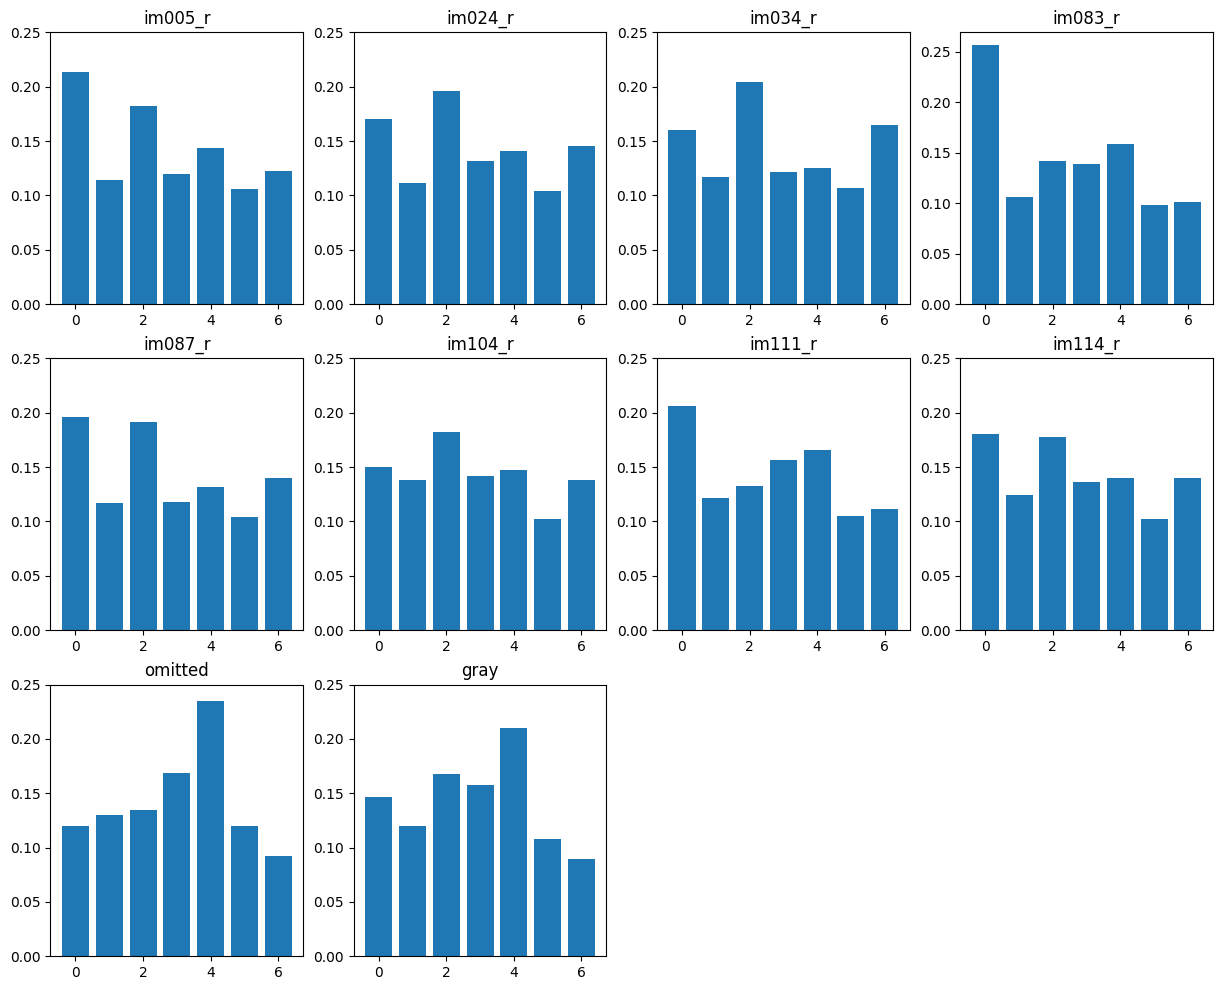

In [417]:
plot_dist(master_time, stim, preds, 7)

##### 4 hidden states

In [16]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=0.1)
model.fit(bands_z_0)
preds = model.predict(bands_z_0)

         1 -30028986.65243211             +nan
         2 -27685985.80393356 +2343000.84849855
         3 -26762844.79426344 +923141.00967012
         4 -26592870.79596932 +169973.99829412
         5 -26561254.91351416  +31615.88245516
         6 -26549364.06814973  +11890.84536443
         7 -26544510.44851369   +4853.61963604
         8 -26542354.77303083   +2155.67548287
         9 -26541337.26624611   +1017.50678472
        10 -26540839.14612660    +498.12011951
        11 -26540572.23350540    +266.91262120
        12 -26540410.87850457    +161.35500083
        13 -26540301.75602928    +109.12247529
        14 -26540220.65304131     +81.10298797
        15 -26540155.68408855     +64.96895276
        16 -26540100.75481215     +54.92927640
        17 -26540052.64455585     +48.11025630
        18 -26540009.74697522     +42.89758063
        19 -26539971.47012300     +38.27685222
        20 -26539937.43493783     +34.03518517
        21 -26539907.15381365     +30.28112418
        22 -

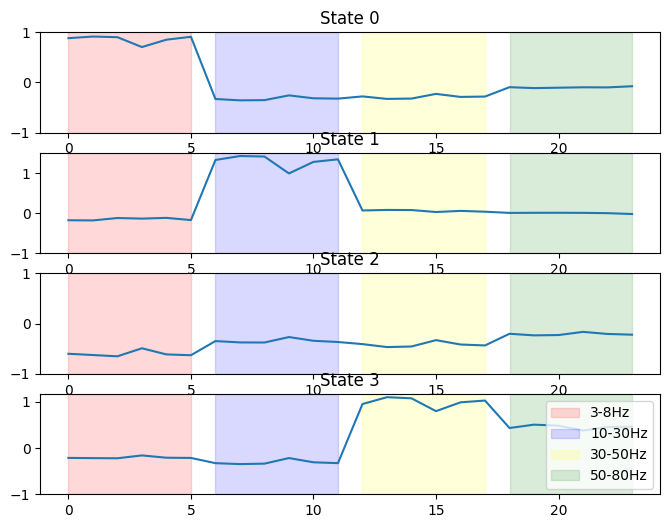

In [78]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].plot(model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

9it [01:10,  7.82s/it]


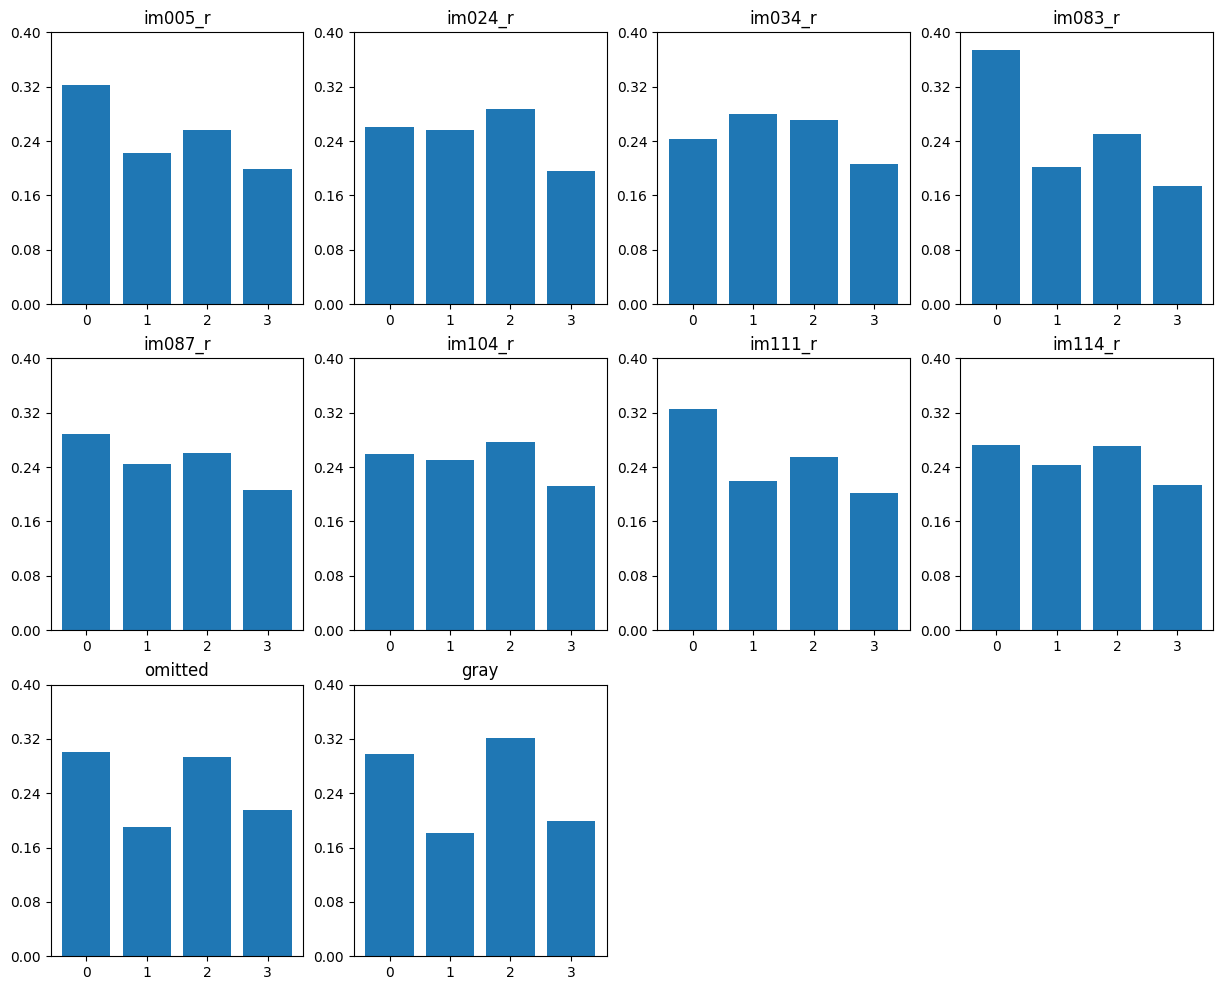

In [30]:
plot_dist(master_time, stim, preds, 4, 0.4)

In [10]:
sp = session.stimulus_presentations[session.stimulus_presentations['stimulus_block']==0]

In [11]:
omitted = sp[sp['omitted']==True]
miss = sp[(sp['is_change']==True) & (sp['rewarded']==False)]
hit = sp[(sp['is_change']==True) & (sp['rewarded']==True)]

3it [00:06,  2.18s/it]


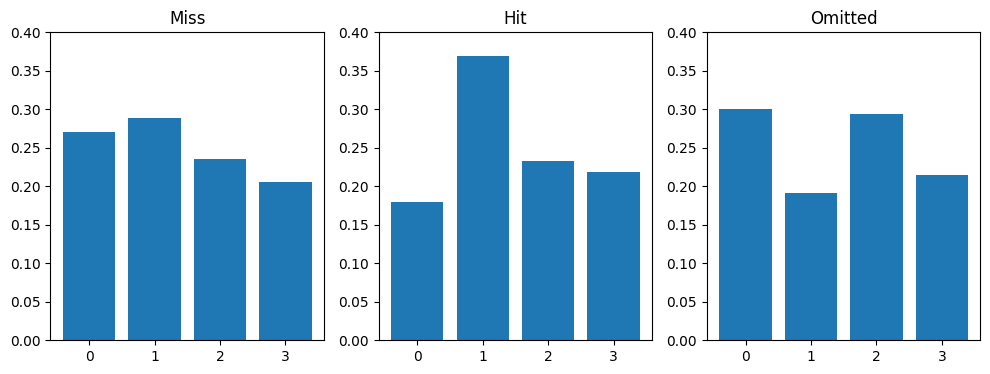

In [67]:
m_t = master_time[100:]
distribution=np.zeros((3, 4))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values

    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3,figsize=(12,4))
axs[0].bar(np.arange(4), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.41,0.05))
axs[1].bar(np.arange(4), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.41,0.05));
axs[2].bar(np.arange(4), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.41,0.05));

In [118]:
model1 = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=0.1)
model1.fit(bands_z_0)
preds = model1.predict(bands_z_0)

         1 -29578401.83829609             +nan
         2 -27058533.64309505 +2519868.19520104
         3 -26650352.62768529 +408181.01540976
         4 -26584847.79092987  +65504.83675543
         5 -26559646.07532162  +25201.71560825
         6 -26549462.57660253  +10183.49871909
         7 -26545107.20341145   +4355.37319108
         8 -26543031.18757793   +2076.01583351
         9 -26541953.41850876   +1077.76906917
        10 -26541344.22244929    +609.19605948
        11 -26540968.95207105    +375.27037824
        12 -26540713.61114376    +255.34092729
        13 -26540527.86252208    +185.74862168
        14 -26540385.46637669    +142.39614540
        15 -26540273.04481480    +112.42156189
        16 -26540181.60450423     +91.44031056
        17 -26540104.84570020     +76.75880403
        18 -26540039.13618503     +65.70951517
        19 -26539982.38271756     +56.75346747
        20 -26539933.04749950     +49.33521806
        21 -26539889.85865879     +43.18884071
        22 -

3it [00:06,  2.29s/it]


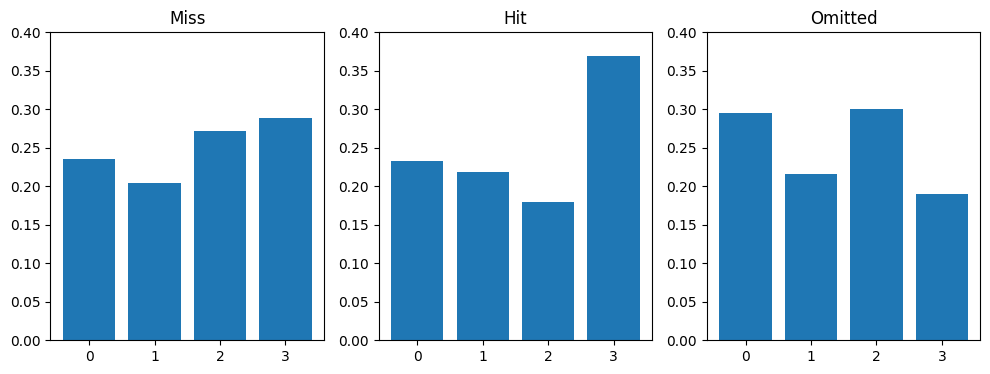

In [121]:
m_t = master_time[250:-250]
distribution=np.zeros((3, 4))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3,figsize=(12,4))
axs[0].bar(np.arange(4), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.41,0.05))
axs[1].bar(np.arange(4), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.41,0.05));
axs[2].bar(np.arange(4), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.41,0.05));

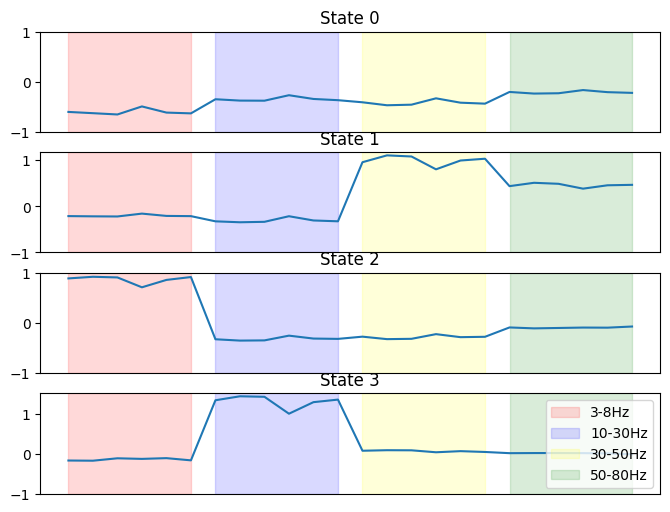

In [123]:
fig, axs=plt.subplots(len(model1.means_),1,figsize=(8,6))
for i in range(len(model1.means_)):
    axs[i].plot(model1.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

In [96]:
mask = np.arange(0,96,6)
all_channels = lfpC_copy[:,mask].T

In [97]:
all_channels.shape

(16, 900941)

In [98]:
bands = np.zeros((4, 16, len(C_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
bands = np.reshape(bands,(4*16, len(A_chan)))
bands = bands[:,100:].T
bands_z_0 = zscore(bands, axis=0)
print(bands.shape)
print(bands_z_0.shape)

(900841, 64)
(900841, 64)


In [99]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=0.1)
model.fit(bands_z_0)
preds = model.predict(bands_z_0)

         1 -79654927.74559742             +nan
         2 -75007807.47834232 +4647120.26725510
         3 -74223612.75211824 +784194.72622408
         4 -74147337.72272930  +76275.02938895
         5 -74121001.43709689  +26336.28563240
         6 -74106131.96378104  +14869.47331585
         7 -74095817.95151670  +10314.01226434
         8 -74088111.52348438   +7706.42803232
         9 -74082195.72579899   +5915.79768538
        10 -74077632.25421530   +4563.47158369
        11 -74074027.68527034   +3604.56894496
        12 -74071032.85081024   +2994.83446009
        13 -74068463.05794869   +2569.79286155
        14 -74066236.02721395   +2227.03073475
        15 -74064191.07145339   +2044.95576055
        16 -74062255.43977113   +1935.63168226
        17 -74060486.00111635   +1769.43865478
        18 -74058889.16731597   +1596.83380038
        19 -74057409.93411426   +1479.23320171
        20 -74056047.32094660   +1362.61316766
        21 -74054785.12680927   +1262.19413733
        22 -

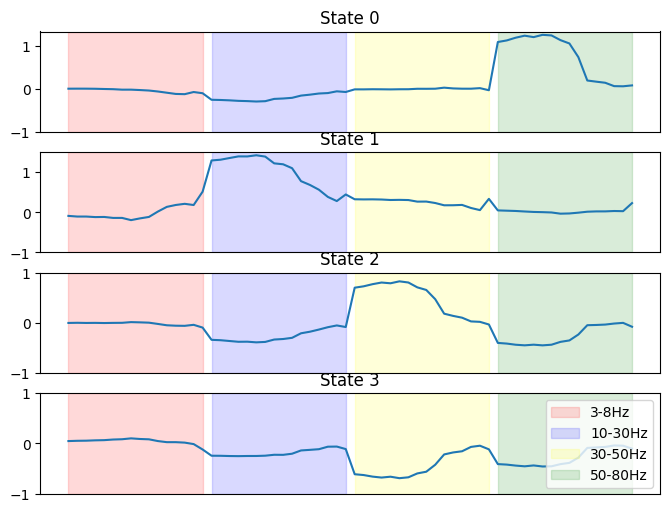

In [100]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].plot(model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 15, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(16, 31, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(32, 47, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(48, 63, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

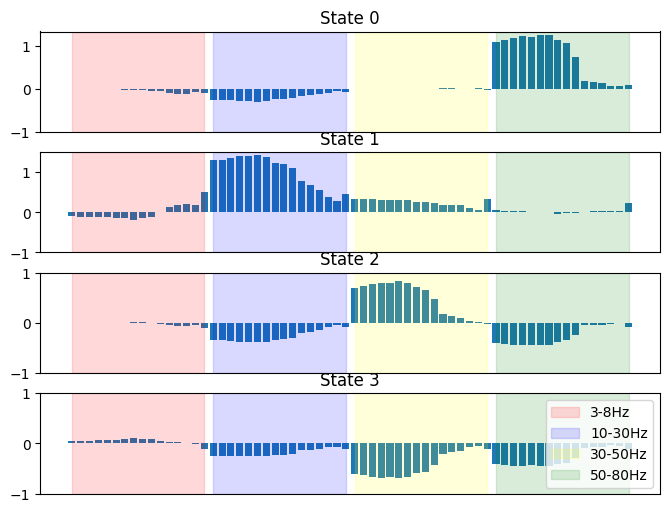

In [303]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].bar(np.arange(64), model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 15, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(16, 31, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(32, 47, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(48, 63, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

##### Power Spectrum

In [12]:
bands = np.zeros((4, 6, len(A_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.vstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env) # type: ignore
    bands[i] = all_channels_env_abs
print(bands.shape)
bands = bands[:,:,250:-250]
print(bands.shape)

(4, 6, 901341)
(4, 6, 900841)


In [14]:
master_time.shape

(901341,)

In [15]:
m_t = master_time[250:-250]

In [45]:
all_env = deepcopy(bands)
hit_starts = find_nearest_idx(m_t, hit.start_time.values-0.250)
hit_ends = find_nearest_idx(m_t, hit.end_time.values+0.5)
miss_starts = find_nearest_idx(m_t, miss.start_time.values-0.250)
miss_ends = find_nearest_idx(m_t, miss.end_time.values+0.5) 
omit_starts = find_nearest_idx(m_t, omitted.start_time.values-0.250)
omit_ends = find_nearest_idx(m_t, omitted.end_time.values+0.5)

In [44]:
# differentiating hit and miss trials
hit_env = np.zeros((4, 250))
miss_env = np.zeros((4, 250))
omit_env = np.zeros((4, 250))
hit_err = 0
miss_err = 0
omit_err = 0
for i in range(4):
    env = all_env[i]
    for j in range(len(hit_starts)):
        avg = np.mean(env[:,hit_starts[j]:hit_ends[j]],axis=0)
        if len(avg) < 250:
            if len(avg) < 250*0.95:
                hit_err+=1
                continue
            else:
                avg = np.append(avg, avg[-1]*(int(250-len(avg))))
        if len(avg) > 250:
            avg = avg[:250]
        hit_env[i] += avg
    for j in range(len(miss_starts)):
        avg = np.mean(env[:,miss_starts[j]:miss_ends[j]],axis=0)
        if len(avg) < 250:
            if len(avg) < 250*0.95:
                miss_err+=1
                continue
            else:
                avg = np.append(avg, avg[-1]*(int(250-len(avg))))
        if len(avg) > 250:
            avg = avg[:250]
        miss_env[i] += avg
    for j in range(len(omit_starts)):
        avg = np.mean(env[:,omit_starts[j]:omit_ends[j]],axis=0)
        if len(avg) < 250:
            if len(avg) < 250*0.95:
                omit_err+=1
                continue
            else:
                avg = np.append(avg, avg[-1]*(int(250-len(avg))))
        if len(avg) > 250:
            avg = avg[:250]
        omit_env[i] += avg

In [48]:
# differentiating hit and miss trials
hit_err = 0
miss_err = 0
omit_err = 0
hit_all = np.zeros((4, len(hit_starts), 6, 250))
miss_all = np.zeros((4, len(miss_starts), 6, 250))
omit_all = np.zeros((4, len(omit_starts), 6, 250))
for i in range(4):
    env = all_env[i]
    for j in range(len(hit_starts)):
        avg = env[:,hit_starts[j]:hit_ends[j]]
        if avg.shape[1] > 250:
            avg = avg[:, :250]
        hit_all[i][j] = avg
    for j in range(len(miss_starts)):
        avg = env[:,miss_starts[j]:miss_ends[j]]
        if avg.shape[1] > 250:
            avg = avg[:, :250]
        miss_all[i][j] = avg
    for j in range(len(omit_starts)):
        avg = env[:,omit_starts[j]:omit_ends[j]]
        if avg.shape[1] < 250:
            if avg.shape[1] < 250*0.95:
                omit_err+=1
                continue
        if avg.shape[1] > 250:
            avg = avg[:, :250]
        omit_all[i][j] = avg

In [56]:
hs = np.reshape(hit_all, (4, len(hit_starts)*6, 250))
ms = np.reshape(miss_all, (4, len(miss_starts)*6, 250))
os = np.reshape(omit_all, (4, len(omit_starts)*6, 250))

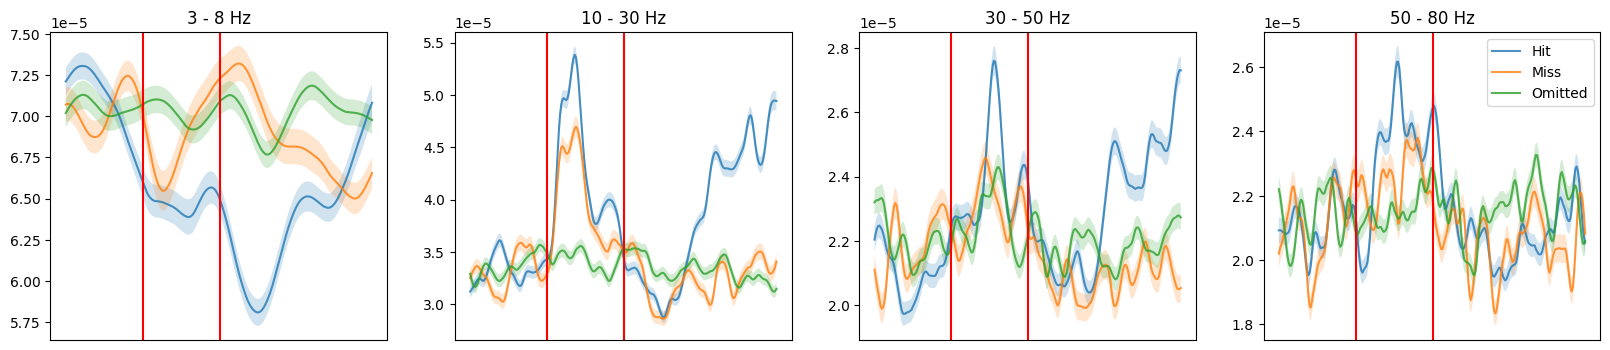

In [86]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, ax in enumerate(axs):
    h = hs[i]
    m = ms[i]
    o = os[i]
    ax.plot(np.mean(h, axis=0), alpha=0.8, label='Hit')
    ax.fill_between(np.arange(250), np.mean(h, axis=0)-sem(h, axis=0), np.mean(h, axis=0)+sem(h, axis=0), alpha=0.2)
    ax.plot(np.mean(m, axis=0), alpha=0.8, label='Miss')
    ax.fill_between(np.arange(250), np.mean(m, axis=0)-sem(m, axis=0), np.mean(m, axis=0)+sem(m, axis=0), alpha=0.2)
    ax.plot(np.mean(o, axis=0), alpha=0.8, label='Omitted')
    ax.fill_between(np.arange(250), np.mean(o, axis=0)-sem(o, axis=0), np.mean(o, axis=0)+sem(o, axis=0), alpha=0.2)
    ax.axvline(250/4, color='r')
    ax.axvline(500/4, color='r')
    ax.xaxis.set_ticks([])
    ax.set_title(f'{Wns[i][0]} - {Wns[i][1]} Hz')
plt.legend();

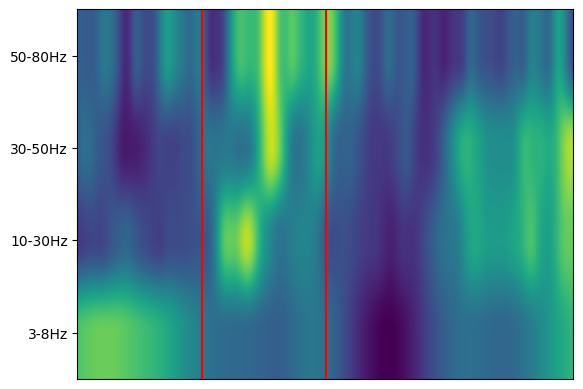

In [235]:
temp=np.array([zscore(np.mean(hs[3], axis=0)),zscore(np.mean(hs[2], axis=0)), zscore(np.mean(hs[1], axis=0)), zscore(np.mean(hs[0], axis=0)),])
plt.imshow(temp, aspect='auto')
plt.axvline(250/4, color='r')
plt.axvline(500/4, color='r')
plt.xticks([]);
plt.yticks([0,1,2,3],['50-80Hz','30-50Hz','10-30Hz','3-8Hz']);

In [245]:
n_f = 100
duration = 250
n_probe = 6

In [246]:
real = np.zeros((n_f, 6, len(A_chan)))
imag = np.zeros((n_f, 6, len(A_chan)))
powers = np.zeros((n_f, 6, len(A_chan)))
Wns = np.arange(1,102,1)
all_channels = np.vstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
for i in tqdm(range(len(Wns)-1)):
    sos = butter(N=3, Wn=[Wns[i], Wns[i+1]], fs=250, btype='bandpass', output='sos')
    all_channels_ff = sosfiltfilt(sos, all_channels)
    all_channels_env = hilbert(all_channels_ff)
    real[i] = np.real(all_channels_env) # type: ignore
    imag[i] = np.imag(all_channels_env) # type: ignore
    powers[i] = real[i]**2 + imag[i]**2
print(powers.shape) # 100 bands, 6 channels(1 channel/probe), 900k samples

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: The length of the input vector x must be greater than padlen, which is 21.

In [231]:
ps = powers[:,:,250:-250]
ps.shape

(10, 6, 900841)

In [232]:

hit_p = np.zeros((n_f, len(hit_starts), n_probe, duration))
miss_p = np.zeros((n_f, len(miss_starts), n_probe, duration))
omit_p = np.zeros((n_f, len(omit_starts), n_probe, duration))
for i in range(n_f):
    p = ps[i]
    for j in range(len(hit_starts)):
        avg = p[:,hit_starts[j]:hit_ends[j]]
        if avg.shape[1] > duration:
            avg = avg[:, :duration]
        hit_p[i][j] = zscore(avg, axis=1)
    for j in range(len(miss_starts)):
        avg = p[:,miss_starts[j]:miss_ends[j]]
        if avg.shape[1] > duration:
            avg = avg[:, :duration]
        miss_p[i][j] = zscore(avg, axis=1)
    for j in range(len(omit_starts)):
        avg = p[:,omit_starts[j]:omit_ends[j]]
        if avg.shape[1] < duration:
            if avg.shape[1] < duration*0.95:
                continue
        if avg.shape[1] > duration:
            avg = avg[:, :duration]
        omit_p[i][j] = zscore(avg, axis=1)

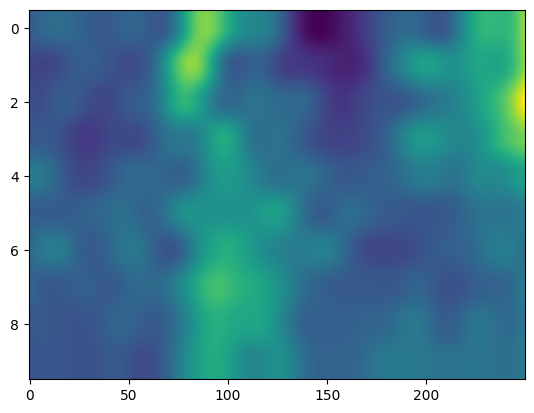

In [233]:
h_p = np.reshape(hit_p, (n_f, len(hit_starts) * n_probe, duration))
h_p_avg = np.mean(h_p, axis=1)
plt.imshow(h_p_avg, aspect='auto')

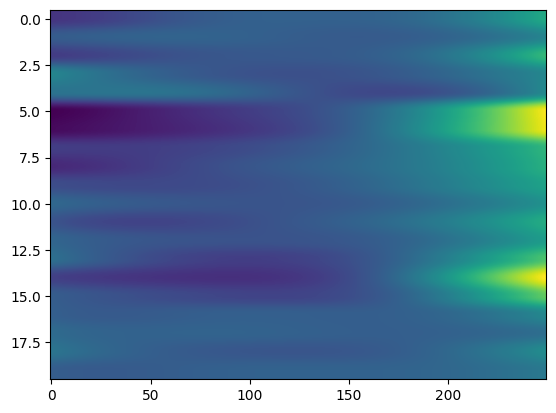

In [216]:
plt.imshow(h_p_avg[10:30], aspect='auto')




In [197]:
f1 = h_p_avg[1]
np.sum(f1)

0.0

In [259]:
# differentiating hit and miss trials
hit_env = np.zeros(100)
miss_env = np.zeros(100)
omit_env = np.zeros(100)
all_env = deepcopy(bands)
hit_starts = find_nearest_idx(m_t, hit.start_time.values)
hit_ends = find_nearest_idx(m_t, hit.end_time.values)
miss_starts = find_nearest_idx(m_t, miss.start_time.values)
miss_ends = find_nearest_idx(m_t, miss.end_time.values)
omit_starts = find_nearest_idx(m_t, omitted.start_time.values)
omit_ends = find_nearest_idx(m_t, omitted.end_time.values)
for i in tqdm(range(100)):
    env = all_env[i]
    for j in range(len(hit_starts)):
        hit_env[i] += np.sum(env[:,hit_starts[j]:hit_ends[j]])
    for j in range(len(miss_starts)):
        miss_env[i] += np.sum(env[:,miss_starts[j]:miss_ends[j]])
    for j in range(len(omit_starts)):
        omit_env[i] += np.sum(env[:,omit_starts[j]:omit_ends[j]])

100%|██████████| 100/100 [00:00<00:00, 313.62it/s]


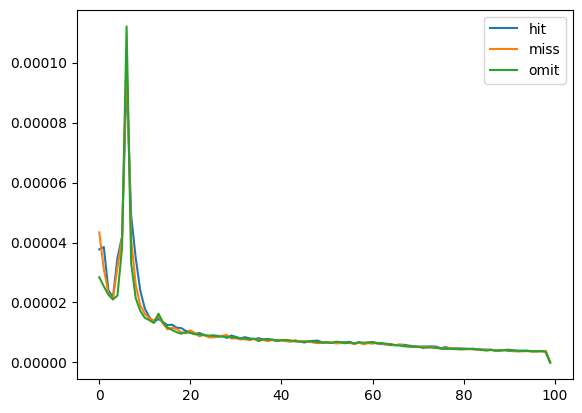

In [293]:
plt.plot(np.arange(100), hit_env/hit_count, label='hit')
plt.plot(np.arange(100), miss_env/miss_count, label='miss')
plt.plot(np.arange(100), omit_env/omit_count, label='omit')
#plt.xticks(ticks=np.arange(4), labels=['3-8Hz','10-30Hz','30-50Hz','50-80Hz'])
plt.legend()

In [287]:
powers = np.zeros((100, 6, len(A_chan)))
real = np.zeros((100, 6, len(A_chan)))
imag = np.zeros((100, 6, len(A_chan)))
Wns = np.arange(1,101,1)
for i in tqdm(range(len(Wns)-1)): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=[Wns[i], Wns[i+1]], fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, A_chan) 
    all_channels_env = hilbert(all_channels_ff)
    real[i] = np.real(all_channels_env)
    imag[i] = np.imag(all_channels_env)
    powers[i] = real[i]**2 + imag[i]**2

100%|██████████| 99/99 [00:35<00:00,  2.77it/s]


In [299]:
imag[0].mean(axis=1)

array([1.92460287e-24, 1.92460287e-24, 1.92460287e-24, 1.92460287e-24,
       1.92460287e-24, 1.92460287e-24])

In [298]:
imag[0].mean(axis=0).mean()

-5.773808611757838e-24

In [285]:
# differentiating hit and miss trials
hit_env2 = np.zeros(100)
miss_env2 = np.zeros(100)
omit_env2 = np.zeros(100)
print(powers.shape)
all_env2 = deepcopy(powers)[:,:,250:-250]
print(all_env2.shape)
for i in range(100):
    env = all_env2[i]
    for j in range(len(hit_starts)):
        hit_env2[i] += np.sum(env[:,hit_starts[j]:hit_ends[j]])
    for j in range(len(miss_starts)):
        miss_env2[i] += np.sum(env[:,miss_starts[j]:miss_ends[j]])
    for j in range(len(omit_starts)):
        omit_env2[i] += np.sum(env[:,omit_starts[j]:omit_ends[j]])

(100, 6, 901341)
(100, 6, 900841)


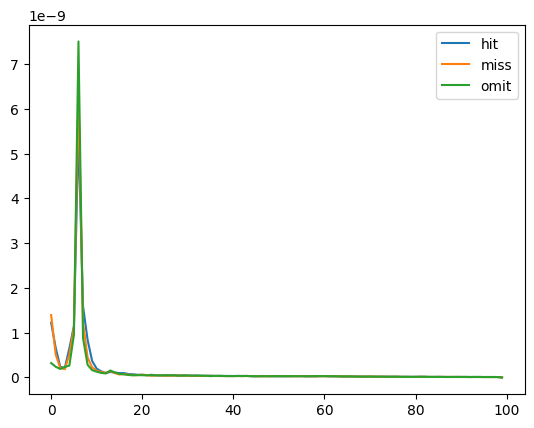

In [286]:
plt.plot(np.arange(100), hit_env2/hit_count, label='hit')
plt.plot(np.arange(100), miss_env2/miss_count, label='miss')
plt.plot(np.arange(100), omit_env2/omit_count, label='omit')
#plt.xticks(ticks=np.arange(4), labels=['3-8Hz','10-30Hz','30-50Hz','50-80Hz'])
plt.legend()

In [183]:
f,t,zxx = stft(A_chan, fs=250, nperseg=1)

In [184]:
np.sum(np.imag(zxx[0]))

0.0

In [129]:
sos = butter(N=3, Wn=[1,2], fs=250, btype='bandpass', output='sos')
all_channels_ff = sosfiltfilt(sos, A_chan)[250:-250]

In [141]:
a_stft = stft(all_channels_ff, fs=250)

In [145]:
len(a_stft)

3

In [146]:
f = a_stft[0]
t = a_stft[1]
zxx = a_stft[2]

In [161]:
from scipy.signal import spectrogram

In [168]:
B_chan

<xarray.DataArray 'LFP' (time: 901341)>
array([ 8.11200e-05,  1.45080e-04,  1.11150e-04, ..., -1.45860e-04,
       -6.31800e-05, -1.11735e-04], dtype=float32)
Coordinates:
  * time     (time) float64 24.24 24.25 24.25 ... 3.63e+03 3.63e+03 3.63e+03
    channel  int64 1145244967

In [171]:
f,t,sxx = spectrogram(np.vstack(A_chan.values), fs=250)

##### Spectrogram